# I. Lý thuyết

1) Tại sao mô hình R-CNN lại có tốc độ xử lý chậm?

Đáp án:

B. Do các vùng region proposal được dự báo bounding box và phân loại nhãn một cách độc lập.



2) Chỉ số mAP trong các thuật toán object detection được tính toán theo cách nào ?

Đáp án:

D. Tính toán chỉ số AP trên từng category: Sắp xếp các Prediction Boxes của một category theo điểm số xác suất giảm dần. Thực hiện matching các Prediction Box với Ground Truth Box sao cho nếu IoU > 0.5 thì được xem là positive và trái lại là negative. Nếu Positive thì Precision sẽ có tử và mẫu cùng tăng lên 1 trong khi Recall có tử số tăng lên 1. Nếu Negative thì Precision có tử giữ nguyên và mẫu tăng lên 1 trong khi Recall không thay đổi. Tính AP = diện tích dưới đường cong Precion Recall. mAP bằng trung bình AP của toàn bộ các category.



3) Phương pháp Non Max Suppression sẽ làm gì để giảm thiểu số lượng các bounding box ?

Đáp án:

D. Dựa vào mức độ overlapping để giữ lại một bounding box có điểm số cao hơn nếu chúng chồng lấn nhau lớn.

4) Trong mô hình Faster R-CNN chúng ta thêm một nhánh mạng RPN có tác dụng gì?

Đáp án:

 
C. Dự báo bounding box và nhãn cho các vùng Region of Interest có khả năng cao chứa vật thể.


5) Anchor Box là gì?

Đáp án:

B. Là những hình chữ nhật với kích thước xác định trước gắn liền với một pixel để làm cơ sở điều chỉnh phần bù (offset) của các tọa độ nhằm dự báo bounding box.



# II. Thực hành 

Các câu bên dưới qui ước chung bounding box đều có tọa độ là (x, y, w, h) lần lượt tương ứng với (x, y) là điểm top-left và (w, h) là kích thước chiều rộng và cao.

6) Xây dựng hàm tính toán IoU giữa hai bounding box.

7) Giả sử các bounding box dự báo cho một category có tọa độ lần lượt là:

[10, 10, 50, 20], [15, 15, 55, 25], [50, 20, 20, 25], [20, 50, 20, 50], [30, 20, 10, 10]

Các bounding box ground truth lần lượt là:

[10, 10, 45, 25], [45, 20, 20, 25], [30, 25, 10, 10]

Hãy thực hiện vẽ đường cong Precision Recall curve và xây dựng thuật toán tính giá trị AP.

8) Thực hiện visualize các anchor box có tỷ lệ aspect ratio (tỷ lệ width/height) lần lượt là 1, 2, 1/2 trên một feature map kích thước 20 x 20

9) Từ bộ dữ liệu [Vinbigdata-chest-xray](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/data) bao gồm các tọa độ bounding box của 14 nhãn của các loại bệnh khác nhau được chuẩn đoán trên ảnh chụp chest X-ray. Thực hiện biến đổi file dữ liệu train.csv sang định dạng COCO json format. Chi tiết mô tả về dữ liệu bạn đọc ở tab data link trên.

10) Hãy xây dựng thuật toán object detection để  hỗ trợ bác sĩ chuẩn đoán bệnh. Để không phải download dữ liệu, bạn nên run một notebook trên kaggle và trích dẫn link sang bài làm của bạn.

##6) Xây dựng hàm tính toán IoU giữa hai bounding box.

In [ ]:
import numpy as np
import torch
box1 = [10, 10, 50, 20]
box2 = [10, 10, 50, 20]

def IoU(box1, box2):
  #box 1
  x1 = box1[0]
  y1 = box1[1]
  w1 = box1[2]
  h1 = box1[3]
  #box 2
  x2 = box2[0]
  y2 = box2[1]
  w2 = box2[2]
  h2 = box2[3]
  # intersect
  #(x11, y11): bottom-right box1
  x11 = x1 + w1
  y11 = y1 + h1
  #(x21, y21): bottom-right box2
  x21 = x2 + w2 
  y21 = y2 + h2

  top_max = max(x1, x2)
  left_max = max(y1, y2)
  bottom_min = min(x11, x21)
  right_min = min(y11, y21)
  # Tìm diện tích của 2 box
  area1 = w1 * h1
  area2 = w2 * h2
  # Tính diện tích vùng giao nhau
  w = max(0, bottom_min - top_max)
  h = max(0, right_min - left_max)
  intersection_area = w*h

  # Tính diện tích phần hợp nhau
  union_area = area1 + area2 - intersection_area

  # Dựa trên phần giao và phần hợp để tính IoU
  IoU_ = intersection_area / union_area

  return float(IoU_)
iou = IoU(box1,  box2)
print(iou)

1.0


##7) Hãy thực hiện vẽ đường cong Precision Recall curve và xây dựng thuật toán tính giá trị AP.

In [ ]:
bbox = [[10, 10, 50, 20], [15, 15, 55, 25], [50, 20, 20, 25], [20, 50, 20, 50], [30, 20, 10, 10]]
gt_box = [[10, 10, 45, 25], [45, 20, 20, 25], [30, 25, 10, 10]]

Precision = []
Recall =[]
a,b = 0,0
Rec = 0
for box in bbox:
  for gt in gt_box:
    iou = IoU(box, gt)
    if iou > 0.5:
      a = a+1
      b = b+1
      Pre = a/b
      Rec = Rec + 1/ 3
      gt_box.remove(gt)
      Precision.append(Pre)
      Recall.append(Rec)
      break
    else:
      if gt == gt_box[-1]:
        b= b+1
        Pre = a/ b
        Precision.append(Pre)
        Recall.append(Rec)
print("Precision: ", Precision)
print("Recall: ", Recall)

Precision:  [1.0, 0.5, 0.6666666666666666, 0.5, 0.4]
Recall:  [0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]


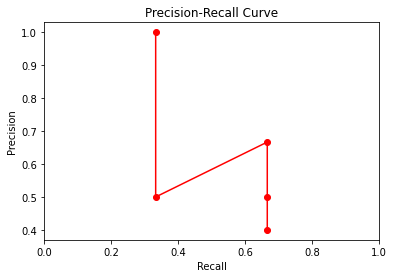

In [ ]:
#calculate precision and recall
import matplotlib.pyplot as plt

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(Recall, Precision, linestyle = '-', marker = 'o',color = "r")

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
# ax.fill_between(Recall,Precision,color='b')
ax.set_xlim(0,1)

#display plot
plt.show()

##8) Thực hiện visualize các anchor box có tỷ lệ aspect ratio (tỷ lệ width/height) lần lượt là 1, 2, 1/2 trên một feature map kích thước 20 x 20

In [ ]:
aspect_ratio =[1, 2, 1/2]
feature_map = 20
box_ = [5,5,5,5]
def anchor_box(box, aspect_ratio):
  x = box[0]
  y = box[1]
  w = box[2]
  h = box[3]

  box_list = []
  for ar in aspect_ratio:
    box_list.append([x, y, float(w)*ar, float(h)/ar])
  return box_list
box_list = anchor_box(box_, aspect_ratio)
print(box_list)

[[5, 5, 5.0, 5.0], [5, 5, 10.0, 2.5], [5, 5, 2.5, 10.0]]


##9) Từ bộ dữ liệu Vinbigdata-chest-xray bao gồm các tọa độ bounding box của 14 nhãn của các loại bệnh khác nhau được chuẩn đoán trên ảnh chụp chest X-ray. Thực hiện biến đổi file dữ liệu train.csv sang định dạng COCO json format. Chi tiết mô tả về dữ liệu bạn đọc ở tab data link trên.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/DL/7.HomeWork_HauTran")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
train = pd.read_csv("../data/Chest-X/train.csv")
train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [ ]:
column_names =['image_id','class_name','class_id', 'rad_id','xmin','ymin','xmax','ymax']

In [ ]:
import numpy as np
import json
import pandas as pd

save_json_path = 'traincoco.json'

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'none'
category["id"] = 1
category["name"] = 'None'
categories.append(category)

train['fileid'] = train['image_id'].astype('category').cat.codes
train['categoryid']= pd.Categorical(train['class_name'],ordered= True).codes
train['categoryid'] = train['categoryid']+1
train['annid'] = train.index

def image(row):
    image = {}
    image["id"] = row.fileid
    image["image_id"] = row.image_id
    image["class_id"]=row.class_id
    image["rad_id"] = row.rad_id
    return image

def category(row):
    category = {}
    category["supercategory"] = row.class_name
    category["id"] = row.categoryid
    category["name"] = row[2]
    return category

def annotation(row):
    annotation = {}
    area = (row.x_max -row.x_min)*(row.y_max - row.y_min)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.x_min, row.y_min, row.x_max -row.x_min,row.y_max-row.y_min ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in train.itertuples():
    annotations.append(annotation(row))

imagedf = train.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

catdf = train.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
for row in catdf.itertuples():
    categories.append(category(row))

train_coco = {}
train_coco["images"] = images
train_coco["categories"] = categories
train_coco["annotations"] = annotations
json.dump(train_coco, open(save_json_path, "w"), indent=4)

In [ ]:
train_coco["images"][10]

{'class_id': 14,
 'id': 10,
 'image_id': '0021df30f3fddef551eb3df4354b1d06',
 'rad_id': 'R8'}

In [ ]:
train_coco["categories"][10]


{'id': 10, 'name': 'Nodule/Mass', 'supercategory': 'Nodule/Mass'}

In [ ]:
train_coco["annotations"][10]

{'area': 57873.0,
 'bbox': [600.0, 1332.0, 303.0, 191.0],
 'category_id': 8,
 'id': 10,
 'image_id': 7244,
 'iscrowd': 0,
 'segmentation': []}

##10) Hãy xây dựng thuật toán object detection để hỗ trợ bác sĩ chuẩn đoán bệnh. Để không phải download dữ liệu, bạn nên run một notebook trên kaggle và trích dẫn link sang bài làm của bạn.

https://www.kaggle.com/tranhau416/pytorch-fasterrcnn